# Grover workflow

In [1]:
import math
import itertools
import numpy as np
import heapq

import qiskit
from qiskit import Aer, QuantumCircuit, execute, QuantumRegister, ClassicalRegister

from purplecaffeine.core import BaseStorage, LocalStorage, Trial
from purplecaffeine.widget import Widget

In [2]:
# Initialize Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')
backend_sim = qasm
local_storage = LocalStorage("./data/")

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

In [4]:
def ram(nb_qram, nb_algo, data, max_value):
    map_ram = list(itertools.product([0, 1], repeat=nb_qram))
    qram = QuantumRegister(nb_qram, 'qram')
    qalgo = QuantumRegister(nb_algo, 'algo')
    qc = QuantumCircuit(qram, qalgo)
        
    # Map data of the dataset here
    for d, m_ram in zip(data, map_ram):
        # Init binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
        
        # We apply the data of the dataset as a percent error of pi.
        for algo in qalgo:
            qc.mcrx(math.acos(1-(d*2/max_value)), qram, algo)
        
        # Close binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
    
    U_s = qc.to_gate()
    U_s.name = "$Qram$"
    return U_s

In [5]:
def algo(nqubits):
    qalgo = QuantumRegister(nqubits, 'algo')
    qc = QuantumCircuit(qalgo)
    
    # Define generic tranformation to apply for every data of the dataset here
    #qc.x(qalgo)
    
    U_s = qc.to_gate()
    U_s.name = "$Algo$"
    return U_s

In [6]:
def launch_circuit(qc):
    qc = qc.reverse_bits()
    job = execute(qc, backend_sim, shots=1024)
    result_job = job.result()
    result_count = result_job.get_counts()

    result_sort = sorted(result_count.items(), key=lambda x: x[1], reverse=True)
    
    return [key for key, value in result_sort[:2]]

In [7]:
def wf_grover(len_qram, len_algo, nb_interations, data, max_value):
    qram = QuantumRegister(len_qram, 'qram')
    qalgo = QuantumRegister(len_algo, 'algo')
    oracle = QuantumRegister(1, 'oracle')
    c = ClassicalRegister(len_qram, 'measurement')

    qc = QuantumCircuit(qram, qalgo, oracle, c)

    # Init
    qc.h(qram)
    qc.x(oracle)
    qc.h(oracle)

    # Qram + Algorithm
    for interation in range(nb_interations):
        qc.append(ram(len_qram, len_algo, data, max_value), [*[i for i in range(len_qram+len_algo)]])
        qc.append(algo(len_algo), [*[i for i in range(len_qram, len_qram+len_algo)]])

        # Oracle
        qc.mcx(qalgo, oracle)

        # Revert Algo + Qram
        qc.append(algo(len_algo).inverse(), [*[i for i in range(len_qram, len_qram+len_algo)]])
        qc.append(ram(len_qram, len_algo, data, max_value).inverse(), [*[i for i in range(len_qram+len_algo)]])

    # Diffuser
    qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])

    # Measure of the ouputs
    qc.measure(qram, c)
    
    return launch_circuit(qc=qc), qc

## Get max value workflow

### Set values

In [8]:
list1 = [6, 30, 90, 12]
list2 = [45, 30]
list3 = [1, 0, 73, 100, 10, 80]
max_value = 100  # If you want to add value below 100, up this one
sub_lists = [list1, list2, list3]
result_2 = []

# Because of memory needs of my server, max is less than the simulator can handle
# More qubit made more precision but also more time and more depth
max_qubits = 15

### Launch workflow

In [9]:
with Trial("Grover workflow", storage=local_storage) as trial:
    for index, submission in enumerate(sub_lists):
        # Data to loaded in the circuit -> our stream list + last results
        data = result_2 + submission
        # Len of the qram
        len_qram = math.ceil(math.log2(len(data)))
        # Number of qubit for the algo -> more it has more precision we get
        len_algo = max_qubits - len_qram
        # Number of time to repeat the transformations
        nb_iterations = 1
        #nb_iterations = math.ceil((np.pi/4)*(math.sqrt(2**len_qram)))

        # Get result from the workflow
        result_2_bin, qc = wf_grover(len_qram, len_algo, nb_iterations, data, max_value)
        result_2 = []
        for bin_value in result_2_bin:
            result_2.append(data[int(bin_value, 2)])

        print("data loaded : ", data)
        print("Result : ", result_2)
        print("Circuit depth : ", qc.decompose().depth())
        print("---")
        
        ## Data loaded
        trial.add_circuit(f"submission #{index}", qc)
        trial.add_parameter("depth", qc.decompose().depth())
        trial.add_parameter("data", data)
        trial.add_parameter("Result", result_2)
        trial.add_parameter("Nb iteration", nb_iterations)
        trial.add_parameter("Len qram", len_qram)
        trial.add_parameter("Len algo", len_algo)
        

    print("Number of qubits : ", max_qubits)
    print("Max tx rotation value : ", max_value)
    print("Final result : ", result_2)
    trial.add_parameter("Max qubits", max_qubits)
    trial.add_parameter("Max tx rotation value", max_value)
    trial.add_parameter("Final result :", result_2)

data loaded :  [6, 30, 90, 12]
Result :  [90, 12]
Circuit depth :  438
---
data loaded :  [90, 12, 45, 30]
Result :  [90, 45]
Circuit depth :  438
---
data loaded :  [90, 45, 1, 0, 73, 100, 10, 80]
Result :  [100, 90]
Circuit depth :  2332
---
Number of qubits :  15
Max tx rotation value :  100
Final result :  [100, 90]


### Data

Full doc : https://icekhan13.github.io/purplecaffeine/  
All the data are stored in the folder `data`.  
To read the file :

In [10]:
local_storage.list()

[<Trial [Grover workflow] 7ce06e24-993f-4dec-93c6-803125035650>,
 <Trial [Grover workflow] 9a2c67e8-c169-48ed-b8e4-ceba0a48d0aa>]

In [20]:
trial_read = local_storage.get("9a2c67e8-c169-48ed-b8e4-ceba0a48d0aa")
print(trial.parameters)

[['depth', 438], ['data', [6, 30, 90, 12]], ['Result', [90, 6]], ['Nb iteration', 1], ['Len qram', 2], ['Len algo', 13], ['depth', 438], ['data', [90, 6, 45, 30]], ['Result', [90, 30]], ['Nb iteration', 1], ['Len qram', 2], ['Len algo', 13], ['depth', 2332], ['data', [90, 30, 1, 0, 73, 100, 10, 80]], ['Result', [100, 90]], ['Nb iteration', 1], ['Len qram', 3], ['Len algo', 12], ['Max qubits', 15], ['Max tx rotation value', 100], ['Final result :', [100, 90]]]


submission #0


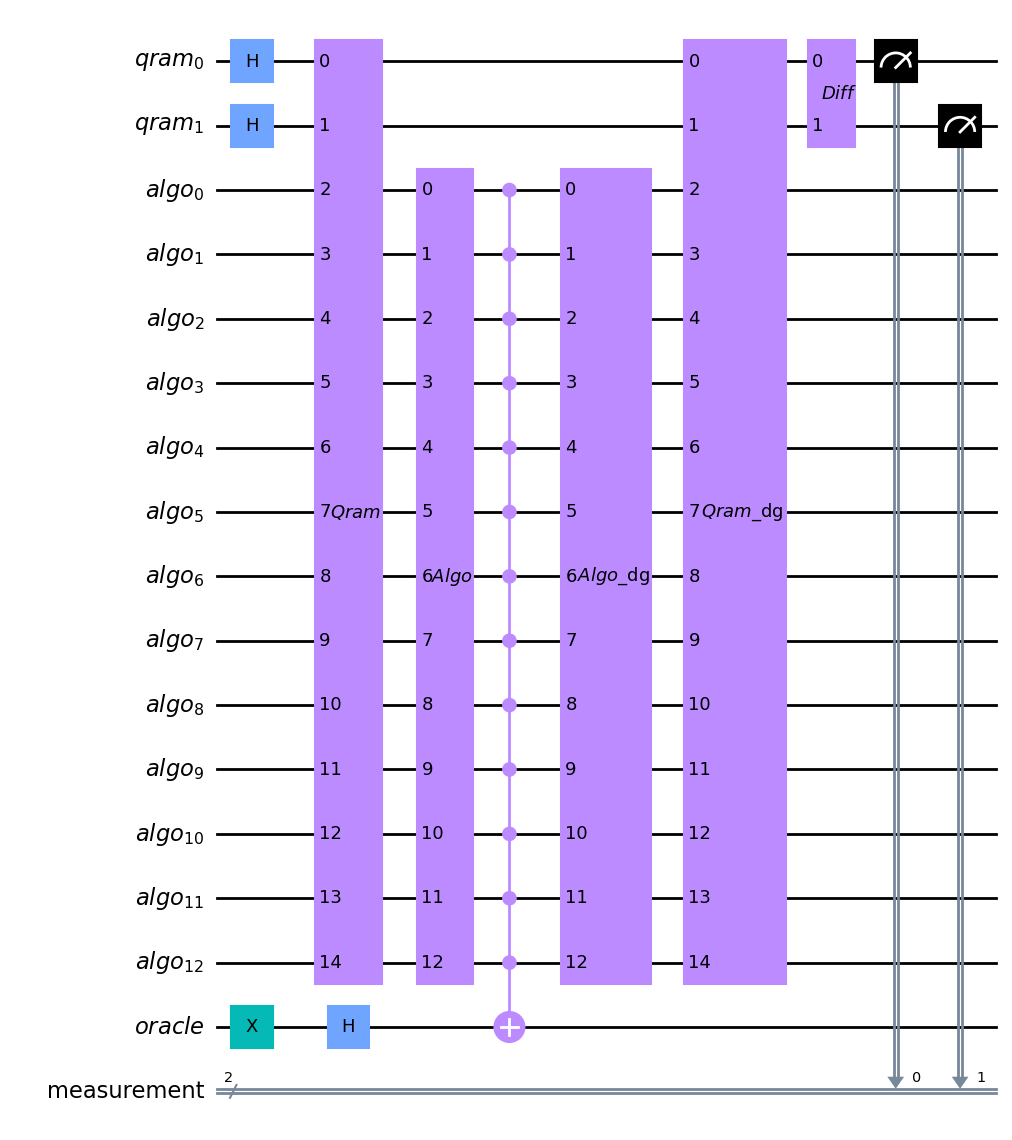

In [23]:
print(trial.circuits[0][0])
trial.circuits[0][1].draw(output="mpl", fold=-1)

In [11]:
Widget(local_storage).show()

GridspecLayout(children=(AppLayout(children=(Button(description='Search', layout=Layout(grid_area='left-sideba…

In [12]:
print(trial.versions)

[['qiskit-terra', '0.24.0'], ['qiskit-aer', '0.12.0'], ['qiskit-ignis', None], ['qiskit-ibmq-provider', '0.20.2'], ['qiskit', '0.43.0'], ['qiskit-nature', '0.6.2'], ['qiskit-finance', '0.3.4'], ['qiskit-optimization', '0.5.0'], ['qiskit-machine-learning', '0.6.1']]
